In [4]:
!pip install properscoring
!pip install copulae

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 782.7 kB/s eta 0:00:00a 0:00:01


In [5]:
import pandas as pd
import numpy as np
from scipy.stats import norm, t, johnsonsu
from scipy import stats
import requests
from io import BytesIO, StringIO
from zipfile import ZipFile
import properscoring as ps
import seaborn as sns
import matplotlib.pyplot as plt
from copulae import GaussianCopula, StudentCopula

from scipy.optimize import minimize, differential_evolution

np.random.seed(607)

In [6]:
# Function for analyzing the factor
def analyze_factor(factor_name, fold1, fold2):
    # Fit models to fold1
    m1 = fold1[factor_name]
    params_normal = norm.fit(m1)
    params_t = t.fit(m1)
    params_johnsonsu = johnsonsu.fit(m1)

    # Select among the three models using CRPS on fold2
    m2 = fold2[factor_name]

    crps_normal = np.mean(ps.crps_ensemble(m2, norm.rvs(*params_normal, size=len(m2))))
    crps_t = np.mean(ps.crps_ensemble(m2, t.rvs(*params_t, size=len(m2))))
    crps_johnsonsu = np.mean(ps.crps_ensemble(m2, johnsonsu.rvs(*params_johnsonsu, size=len(m2))))

    # Report the best model and the fitted parameters
    best_model = min([(crps_normal, 'Normal', params_normal),
                      (crps_t, 'Student t', params_t),
                      (crps_johnsonsu, 'Johnson Su', params_johnsonsu)], key=lambda x: x[0])

    print(f"Best model for {factor_name}: {best_model[1]}")
    print(f"Fitted parameters for {factor_name}: {best_model[2]}")

    # Compute PIT values for the chosen model on fold 2
    if best_model[1] == 'Normal':
        cdf_values = norm.cdf(m2, *params_normal)
    elif best_model[1] == 'Student t':
        cdf_values = t.cdf(m2, *params_t)
    elif best_model[1] == 'Johnson Su':
        cdf_values = johnsonsu.cdf(m2, *params_johnsonsu)

    # # Plot PIT values
    # plt.figure(figsize=(4, 4))

    # sns.histplot(cdf_values, bins=20, cumulative=True, alpha=0.75)
    # sns.histplot(cdf_values, bins=20, color='red', alpha=0.75)
    # plt.title(f'PDF and CDF for PIT Values of the Chosen Model ({factor_name})')

    # plt.show()

    return best_model
    
def compute_pit_fold1(factor_name, fold1, best_model):
    m1 = fold1[factor_name]

    if best_model[1] == 'Normal':
        cdf_values = norm.cdf(m1, *best_model[2])
    elif best_model[1] == 'Student t':
        cdf_values = t.cdf(m1, *best_model[2])
    elif best_model[1] == 'Johnson Su':
        cdf_values = johnsonsu.cdf(m1, *best_model[2])

    return cdf_values
   

In [7]:
# Step 1: Download data from Ken French's website
url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip"
response = requests.get(url)

import warnings
warnings.filterwarnings("ignore")

with ZipFile(BytesIO(response.content)) as zfile:
    with zfile.open('F-F_Research_Data_Factors.CSV') as file:
        csv_data = pd.read_csv(file, skiprows=3, index_col=0)

# Convert the data to numeric format and drop rows with missing values
csv_data = csv_data.apply(pd.to_numeric, errors='coerce').dropna()

# Keep only the monthly observations
csv_data = csv_data[csv_data.index.map(lambda x: x.isdigit() and len(x) == 6)]

# Step 2: Compute m
csv_data['m'] = (csv_data['Mkt-RF'] / 100) / (1 + csv_data['RF'] / 100)
csv_data['Mkt'] = csv_data['Mkt-RF'] + csv_data['RF']
csv_data['hml'] = (csv_data['HML'] / 100) / (1 + csv_data['RF'] / 100)
csv_data['smb'] = (csv_data['SMB'] / 100) / (1 + csv_data['RF'] / 100)

# Step 3: Split data into folds
fold1 = csv_data.loc['192607':'198312']
fold2 = csv_data.loc['198301':'201212']
fold3 = csv_data.loc['201301':'201812']
fold4 = csv_data.loc['201901':]
    
# Step 4, 5, 6, 7: Analyze the factors, compute PIT values for fold1, and plot scatter plot
factors = ['m', 'hml', 'smb']
best_model = {}
pit_values = {}

for factor in factors:
    best_model[factor] = analyze_factor(factor, fold1, fold2)
    pit_values[factor] = compute_pit_fold1(factor, fold1, best_model[factor])
    

Best model for m: Student t
Fitted parameters for m: (3.4521298217216843, 0.008635493468786549, 0.03801716366296638)
Best model for hml: Student t
Fitted parameters for hml: (2.576925003219193, 0.0020010206911395003, 0.019883798626802035)
Best model for smb: Johnson Su
Fitted parameters for smb: (-0.20427038139388667, 1.4030329290662709, -0.0033247496754230414, 0.032036357928795)


In [8]:
# Combine the PIT values into a DataFrame
pit_df = pd.DataFrame(pit_values)

In [9]:
# Fit the  Student t Copula
copula_Student = StudentCopula(dim=3)
copula_Student.fit(pit_df)

sampled_Student = copula_Student.random(len(fold1))
sampled_df_Student = pd.DataFrame(sampled_Student, columns=pit_df.columns)

                m         hml         smb
count  690.000000  690.000000  690.000000
mean     0.500000    0.500000    0.500000
std      0.288466    0.288466    0.288466
min      0.001447    0.001447    0.001447
25%      0.250724    0.250724    0.250724
50%      0.500000    0.500000    0.500000
75%      0.749276    0.749276    0.749276
max      0.998553    0.998553    0.998553


# Set the stage for portfolio optimization

In [10]:
# Draw the correlated uniforms
n_simulations = 2000
uniform_data = copula_Student.random(n_simulations)

In [15]:
# Compute the inverse cumulative distribution functions for m, hml, and smb
# simulated_returns = {}
# simulated_returns[0] = stats.t.ppf(uniform_data[:,0], best_model['m'][2][0], loc=best_model['m'][2][1], scale=best_model['m'][2][2])
# simulated_returns[1] = stats.t.ppf(uniform_data[:,1], best_model['hml'][2][0],loc=best_model['hml'][2][1], scale=best_model['hml'][2][2])
# simulated_returns[2] = stats.johnsonsu.ppf(uniform_data[:,2], best_model['smb'][2][0],best_model['smb'][2][1],best_model['smb'][2][2],best_model['smb'][2][3])

In [16]:
simulated_returns = {}
simulated_returns[0] = stats.t.ppf(uniform_data.iloc[:,0], best_model['m'][2][0], loc=best_model['m'][2][1], scale=best_model['m'][2][2])
simulated_returns[1] = stats.t.ppf(uniform_data.iloc[:,1], best_model['hml'][2][0], loc=best_model['hml'][2][1], scale=best_model['hml'][2][2])
simulated_returns[2] = stats.johnsonsu.ppf(uniform_data.iloc[:,2], best_model['smb'][2][0], best_model['smb'][2][1], best_model['smb'][2][2], best_model['smb'][2][3])

In [17]:
# Create a DataFrame from simulated_returns_np
simulated_returns_df = pd.DataFrame(simulated_returns)
simulated_returns_df.rename(columns={0: 'm', 1: 'hml', 2: 'smb'}, inplace=True)

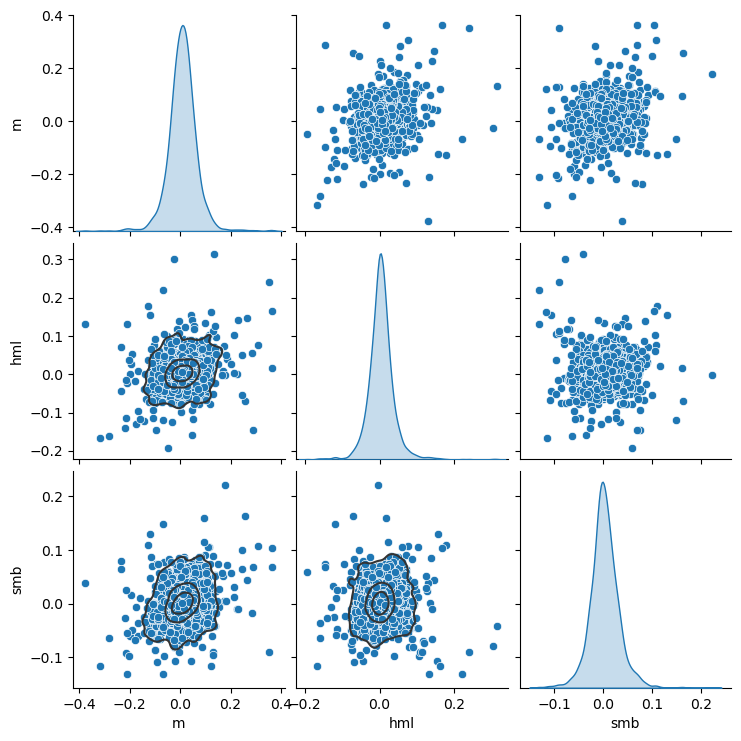

In [18]:
g = sns.pairplot(simulated_returns_df, diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color=".2")

In [ ]:
def modified_crra_utility(x, risk_aversion):
    # Avoid non-positive values
    if x < 0:
        return float('-inf')
    if x == 0 and risk_aversion >= 1:
        return float('-inf')
    if risk_aversion == 1:
        return np.log(x)
    else:
        return (x**(1 - risk_aversion) - 1) / (1 - risk_aversion)

In [12]:
def expected_utility(f, simulated_returns_df, risk_aversion):
    f_0, f_1 = f
    expectation = 0
    count = 0
    
    for _, row in simulated_returns_df.iterrows():
        m = row['m']
        hml = row['hml']
        smb = row['smb']
        utility = modified_crra_utility(1 + f_0 * m + f_1 * hml + (1 - f_0 - f_1) * smb, risk_aversion)
        expectation += utility
        count += 1
    
    return -1 * (expectation / count)

In [13]:
def max_expected_utility(simulated_returns_df, risk_aversion):
    initial_guess = [0.8, 0.8]
    bounds = [(-4, 4), (-4, 4)]
    
    result = minimize(expected_utility, initial_guess, args=(simulated_returns_df, risk_aversion), bounds=bounds, method='L-BFGS-B')
    # Alternatively, use differential_evolution
    # result = differential_evolution(expected_utility, bounds, args=(simulated_returns_df, risk_aversion))
    
    return result.x

# Results

In [18]:
risk_aversion = 1

optimal_weights = max_expected_utility(simulated_returns_df, risk_aversion)

print("Optimal weights: ", optimal_weights,",",1 - optimal_weights[0] - optimal_weights[1])


Optimal weights:  [1.84771145 0.34739942] , -1.1951108772384615
